# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 6299648/11490434 [===============>..............] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:58 - loss: 0.6917

  29/1875 [..............................] - ETA: 3s - loss: 0.5380   

  56/1875 [..............................] - ETA: 3s - loss: 0.4636

  84/1875 [>.............................] - ETA: 3s - loss: 0.4220

 113/1875 [>.............................] - ETA: 3s - loss: 0.3946

 145/1875 [=>............................] - ETA: 3s - loss: 0.3734

 175/1875 [=>............................] - ETA: 3s - loss: 0.3583

 207/1875 [==>...........................] - ETA: 2s - loss: 0.3453

 238/1875 [==>...........................] - ETA: 2s - loss: 0.3347

 265/1875 [===>..........................] - ETA: 2s - loss: 0.3266

 290/1875 [===>..........................] - ETA: 2s - loss: 0.3200

 317/1875 [====>.........................] - ETA: 2s - loss: 0.3135

 346/1875 [====>.........................] - ETA: 2s - loss: 0.3071

 377/1875 [=====>........................] - ETA: 2s - loss: 0.3010

 408/1875 [=====>........................] - ETA: 2s - loss: 0.2954

 438/1875 [======>.......................] - ETA: 2s - loss: 0.2904

 470/1875 [======>.......................] - ETA: 2s - loss: 0.2855

 500/1875 [=======>......................] - ETA: 2s - loss: 0.2813

 523/1875 [=======>......................] - ETA: 2s - loss: 0.2782

 552/1875 [=======>......................] - ETA: 2s - loss: 0.2746

 578/1875 [========>.....................] - ETA: 2s - loss: 0.2715

 609/1875 [========>.....................] - ETA: 2s - loss: 0.2681

 641/1875 [=========>....................] - ETA: 2s - loss: 0.2647

 669/1875 [=========>....................] - ETA: 2s - loss: 0.2619

 699/1875 [==========>...................] - ETA: 2s - loss: 0.2591

 726/1875 [==========>...................] - ETA: 2s - loss: 0.2567

 751/1875 [===========>..................] - ETA: 1s - loss: 0.2545

 780/1875 [===========>..................] - ETA: 1s - loss: 0.2521

 808/1875 [===========>..................] - ETA: 1s - loss: 0.2499

 837/1875 [============>.................] - ETA: 1s - loss: 0.2477

 865/1875 [============>.................] - ETA: 1s - loss: 0.2456

 893/1875 [=============>................] - ETA: 1s - loss: 0.2437

 924/1875 [=============>................] - ETA: 1s - loss: 0.2416

 950/1875 [==============>...............] - ETA: 1s - loss: 0.2399

 978/1875 [==============>...............] - ETA: 1s - loss: 0.2381

1007/1875 [===============>..............] - ETA: 1s - loss: 0.2363

1043/1875 [===============>..............] - ETA: 1s - loss: 0.2342

1080/1875 [================>.............] - ETA: 1s - loss: 0.2322

1118/1875 [================>.............] - ETA: 1s - loss: 0.2301

1155/1875 [=================>............] - ETA: 1s - loss: 0.2282

1191/1875 [==================>...........] - ETA: 1s - loss: 0.2264

1220/1875 [==================>...........] - ETA: 1s - loss: 0.2250

1253/1875 [===================>..........] - ETA: 1s - loss: 0.2235

1280/1875 [===================>..........] - ETA: 1s - loss: 0.2223

1304/1875 [===================>..........] - ETA: 0s - loss: 0.2212

1336/1875 [====================>.........] - ETA: 0s - loss: 0.2198

1367/1875 [====================>.........] - ETA: 0s - loss: 0.2185

1399/1875 [=====================>........] - ETA: 0s - loss: 0.2172

1428/1875 [=====================>........] - ETA: 0s - loss: 0.2161

1456/1875 [======================>.......] - ETA: 0s - loss: 0.2150

1485/1875 [======================>.......] - ETA: 0s - loss: 0.2139

1509/1875 [=======================>......] - ETA: 0s - loss: 0.2130

1537/1875 [=======================>......] - ETA: 0s - loss: 0.2120

1560/1875 [=======================>......] - ETA: 0s - loss: 0.2112

1587/1875 [========================>.....] - ETA: 0s - loss: 0.2103

1614/1875 [========================>.....] - ETA: 0s - loss: 0.2093

1644/1875 [=========================>....] - ETA: 0s - loss: 0.2083

1672/1875 [=========================>....] - ETA: 0s - loss: 0.2074

1703/1875 [==========================>...] - ETA: 0s - loss: 0.2065

1734/1875 [==========================>...] - ETA: 0s - loss: 0.2055

1764/1875 [===========================>..] - ETA: 0s - loss: 0.2046

1793/1875 [===========================>..] - ETA: 0s - loss: 0.2037

1824/1875 [============================>.] - ETA: 0s - loss: 0.2028

1853/1875 [============================>.] - ETA: 0s - loss: 0.2020

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2013


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1206

  32/1875 [..............................] - ETA: 3s - loss: 0.1106

  63/1875 [>.............................] - ETA: 2s - loss: 0.1101

  93/1875 [>.............................] - ETA: 2s - loss: 0.1099

 122/1875 [>.............................] - ETA: 2s - loss: 0.1097

 153/1875 [=>............................] - ETA: 2s - loss: 0.1096

 183/1875 [=>............................] - ETA: 2s - loss: 0.1095

 214/1875 [==>...........................] - ETA: 2s - loss: 0.1093

 243/1875 [==>...........................] - ETA: 2s - loss: 0.1092

 267/1875 [===>..........................] - ETA: 2s - loss: 0.1092

 298/1875 [===>..........................] - ETA: 2s - loss: 0.1090

 329/1875 [====>.........................] - ETA: 2s - loss: 0.1089

 360/1875 [====>.........................] - ETA: 2s - loss: 0.1088

 392/1875 [=====>........................] - ETA: 2s - loss: 0.1087

 424/1875 [=====>........................] - ETA: 2s - loss: 0.1085

 455/1875 [======>.......................] - ETA: 2s - loss: 0.1084

 486/1875 [======>.......................] - ETA: 2s - loss: 0.1083

 517/1875 [=======>......................] - ETA: 2s - loss: 0.1082

 548/1875 [=======>......................] - ETA: 2s - loss: 0.1081

 571/1875 [========>.....................] - ETA: 2s - loss: 0.1080

 597/1875 [========>.....................] - ETA: 2s - loss: 0.1079

 627/1875 [=========>....................] - ETA: 2s - loss: 0.1078

 656/1875 [=========>....................] - ETA: 2s - loss: 0.1078

 686/1875 [=========>....................] - ETA: 2s - loss: 0.1077

 715/1875 [==========>...................] - ETA: 1s - loss: 0.1076

 745/1875 [==========>...................] - ETA: 1s - loss: 0.1075

 775/1875 [===========>..................] - ETA: 1s - loss: 0.1074

 802/1875 [===========>..................] - ETA: 1s - loss: 0.1074

 831/1875 [============>.................] - ETA: 1s - loss: 0.1073

 857/1875 [============>.................] - ETA: 1s - loss: 0.1072

 885/1875 [=============>................] - ETA: 1s - loss: 0.1071

 915/1875 [=============>................] - ETA: 1s - loss: 0.1071

 946/1875 [==============>...............] - ETA: 1s - loss: 0.1070

 977/1875 [==============>...............] - ETA: 1s - loss: 0.1069

1007/1875 [===============>..............] - ETA: 1s - loss: 0.1068

1037/1875 [===============>..............] - ETA: 1s - loss: 0.1068

1066/1875 [================>.............] - ETA: 1s - loss: 0.1067

1096/1875 [================>.............] - ETA: 1s - loss: 0.1066

1126/1875 [=================>............] - ETA: 1s - loss: 0.1066

1154/1875 [=================>............] - ETA: 1s - loss: 0.1065

1184/1875 [=================>............] - ETA: 1s - loss: 0.1064

1214/1875 [==================>...........] - ETA: 1s - loss: 0.1064

1244/1875 [==================>...........] - ETA: 1s - loss: 0.1063

1274/1875 [===================>..........] - ETA: 1s - loss: 0.1063

1304/1875 [===================>..........] - ETA: 0s - loss: 0.1062

1335/1875 [====================>.........] - ETA: 0s - loss: 0.1061

1366/1875 [====================>.........] - ETA: 0s - loss: 0.1061

1397/1875 [=====================>........] - ETA: 0s - loss: 0.1060

1427/1875 [=====================>........] - ETA: 0s - loss: 0.1059

1455/1875 [======================>.......] - ETA: 0s - loss: 0.1059

1476/1875 [======================>.......] - ETA: 0s - loss: 0.1059

1502/1875 [=======================>......] - ETA: 0s - loss: 0.1058

1527/1875 [=======================>......] - ETA: 0s - loss: 0.1058

1554/1875 [=======================>......] - ETA: 0s - loss: 0.1057

1584/1875 [========================>.....] - ETA: 0s - loss: 0.1057

1615/1875 [========================>.....] - ETA: 0s - loss: 0.1056

1645/1875 [=========================>....] - ETA: 0s - loss: 0.1056

1674/1875 [=========================>....] - ETA: 0s - loss: 0.1055

1705/1875 [==========================>...] - ETA: 0s - loss: 0.1054

1733/1875 [==========================>...] - ETA: 0s - loss: 0.1054

1763/1875 [===========================>..] - ETA: 0s - loss: 0.1054

1794/1875 [===========================>..] - ETA: 0s - loss: 0.1053

1824/1875 [============================>.] - ETA: 0s - loss: 0.1053

1854/1875 [============================>.] - ETA: 0s - loss: 0.1052

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1052


Epoch 3/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0939

  32/1875 [..............................] - ETA: 2s - loss: 0.0969

  63/1875 [>.............................] - ETA: 2s - loss: 0.0975

  93/1875 [>.............................] - ETA: 2s - loss: 0.0979

 124/1875 [>.............................] - ETA: 2s - loss: 0.0981

 155/1875 [=>............................] - ETA: 2s - loss: 0.0982

 180/1875 [=>............................] - ETA: 2s - loss: 0.0982

 211/1875 [==>...........................] - ETA: 2s - loss: 0.0982

 242/1875 [==>...........................] - ETA: 2s - loss: 0.0982

 274/1875 [===>..........................] - ETA: 2s - loss: 0.0982

 305/1875 [===>..........................] - ETA: 2s - loss: 0.0982

 336/1875 [====>.........................] - ETA: 2s - loss: 0.0982

 367/1875 [====>.........................] - ETA: 2s - loss: 0.0982

 397/1875 [=====>........................] - ETA: 2s - loss: 0.0982

 427/1875 [=====>........................] - ETA: 2s - loss: 0.0982

 454/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 479/1875 [======>.......................] - ETA: 2s - loss: 0.0981

 504/1875 [=======>......................] - ETA: 2s - loss: 0.0981

 533/1875 [=======>......................] - ETA: 2s - loss: 0.0981

 560/1875 [=======>......................] - ETA: 2s - loss: 0.0981

 587/1875 [========>.....................] - ETA: 2s - loss: 0.0981

 616/1875 [========>.....................] - ETA: 2s - loss: 0.0981

 645/1875 [=========>....................] - ETA: 2s - loss: 0.0981

 674/1875 [=========>....................] - ETA: 2s - loss: 0.0980

 704/1875 [==========>...................] - ETA: 2s - loss: 0.0980

 726/1875 [==========>...................] - ETA: 2s - loss: 0.0980

 746/1875 [==========>...................] - ETA: 2s - loss: 0.0980

 773/1875 [===========>..................] - ETA: 1s - loss: 0.0980

 802/1875 [===========>..................] - ETA: 1s - loss: 0.0980

 833/1875 [============>.................] - ETA: 1s - loss: 0.0980

 864/1875 [============>.................] - ETA: 1s - loss: 0.0980

 895/1875 [=============>................] - ETA: 1s - loss: 0.0980

 925/1875 [=============>................] - ETA: 1s - loss: 0.0980

 956/1875 [==============>...............] - ETA: 1s - loss: 0.0979

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0979

1016/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1047/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1077/1875 [================>.............] - ETA: 1s - loss: 0.0979

1107/1875 [================>.............] - ETA: 1s - loss: 0.0979

1137/1875 [=================>............] - ETA: 1s - loss: 0.0979

1167/1875 [=================>............] - ETA: 1s - loss: 0.0979

1197/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1227/1875 [==================>...........] - ETA: 1s - loss: 0.0978

1257/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1287/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1312/1875 [===================>..........] - ETA: 0s - loss: 0.0978

1342/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1372/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1403/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1463/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1490/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1517/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1540/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1594/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1621/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1707/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1769/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1830/1875 [============================>.] - ETA: 0s - loss: 0.0976

1861/1875 [============================>.] - ETA: 0s - loss: 0.0976

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0976


Epoch 4/5
   1/1875 [..............................] - ETA: 8s - loss: 0.0949

  30/1875 [..............................] - ETA: 3s - loss: 0.0944

  61/1875 [..............................] - ETA: 3s - loss: 0.0950

  92/1875 [>.............................] - ETA: 2s - loss: 0.0954

 123/1875 [>.............................] - ETA: 2s - loss: 0.0955

 152/1875 [=>............................] - ETA: 2s - loss: 0.0955

 183/1875 [=>............................] - ETA: 2s - loss: 0.0956

 214/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 244/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 275/1875 [===>..........................] - ETA: 2s - loss: 0.0957

 304/1875 [===>..........................] - ETA: 2s - loss: 0.0957

 337/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 366/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 395/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 421/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 450/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 473/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 501/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 525/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 552/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 581/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 612/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 642/1875 [=========>....................] - ETA: 2s - loss: 0.0959

 672/1875 [=========>....................] - ETA: 2s - loss: 0.0959

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0959

 732/1875 [==========>...................] - ETA: 1s - loss: 0.0959

 763/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 793/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 823/1875 [============>.................] - ETA: 1s - loss: 0.0959

 853/1875 [============>.................] - ETA: 1s - loss: 0.0959

 882/1875 [=============>................] - ETA: 1s - loss: 0.0959

 912/1875 [=============>................] - ETA: 1s - loss: 0.0959

 941/1875 [==============>...............] - ETA: 1s - loss: 0.0959

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0959

1001/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1031/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1061/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1091/1875 [================>.............] - ETA: 1s - loss: 0.0959

1120/1875 [================>.............] - ETA: 1s - loss: 0.0959

1151/1875 [=================>............] - ETA: 1s - loss: 0.0959

1169/1875 [=================>............] - ETA: 1s - loss: 0.0959

1197/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1249/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1278/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1305/1875 [===================>..........] - ETA: 0s - loss: 0.0959

1331/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1360/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1385/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1412/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1441/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1555/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1581/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1602/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1677/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1728/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1828/1875 [============================>.] - ETA: 0s - loss: 0.0959

1853/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0959


Epoch 5/5


   1/1875 [..............................] - ETA: 3s - loss: 0.0992

  33/1875 [..............................] - ETA: 2s - loss: 0.0970



  57/1875 [..............................] - ETA: 3s - loss: 0.0972

  86/1875 [>.............................] - ETA: 3s - loss: 0.0970

 117/1875 [>.............................] - ETA: 3s - loss: 0.0967

 147/1875 [=>............................] - ETA: 3s - loss: 0.0965

 176/1875 [=>............................] - ETA: 2s - loss: 0.0964

 204/1875 [==>...........................] - ETA: 2s - loss: 0.0963

 233/1875 [==>...........................] - ETA: 2s - loss: 0.0962

 261/1875 [===>..........................] - ETA: 2s - loss: 0.0962

 292/1875 [===>..........................] - ETA: 2s - loss: 0.0961

 323/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 354/1875 [====>.........................] - ETA: 2s - loss: 0.0960

 384/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 413/1875 [=====>........................] - ETA: 2s - loss: 0.0959

 443/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 473/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 503/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 532/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 561/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 590/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 620/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 650/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 679/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 709/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 738/1875 [==========>...................] - ETA: 1s - loss: 0.0958

 768/1875 [===========>..................] - ETA: 1s - loss: 0.0958

 798/1875 [===========>..................] - ETA: 1s - loss: 0.0958

 828/1875 [============>.................] - ETA: 1s - loss: 0.0958

 859/1875 [============>.................] - ETA: 1s - loss: 0.0957

 890/1875 [=============>................] - ETA: 1s - loss: 0.0957

 921/1875 [=============>................] - ETA: 1s - loss: 0.0957

 952/1875 [==============>...............] - ETA: 1s - loss: 0.0957

 981/1875 [==============>...............] - ETA: 1s - loss: 0.0957

1010/1875 [===============>..............] - ETA: 1s - loss: 0.0957

1040/1875 [===============>..............] - ETA: 1s - loss: 0.0957

1069/1875 [================>.............] - ETA: 1s - loss: 0.0957

1099/1875 [================>.............] - ETA: 1s - loss: 0.0957

1129/1875 [=================>............] - ETA: 1s - loss: 0.0957

1160/1875 [=================>............] - ETA: 1s - loss: 0.0957

1190/1875 [==================>...........] - ETA: 1s - loss: 0.0957

1220/1875 [==================>...........] - ETA: 1s - loss: 0.0957

1250/1875 [===================>..........] - ETA: 1s - loss: 0.0957

1280/1875 [===================>..........] - ETA: 1s - loss: 0.0957

1310/1875 [===================>..........] - ETA: 0s - loss: 0.0956

1338/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1367/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1395/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1426/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1456/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1487/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1548/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1576/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1606/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1819/1875 [============================>.] - ETA: 0s - loss: 0.0956

1849/1875 [============================>.] - ETA: 0s - loss: 0.0956

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0956


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

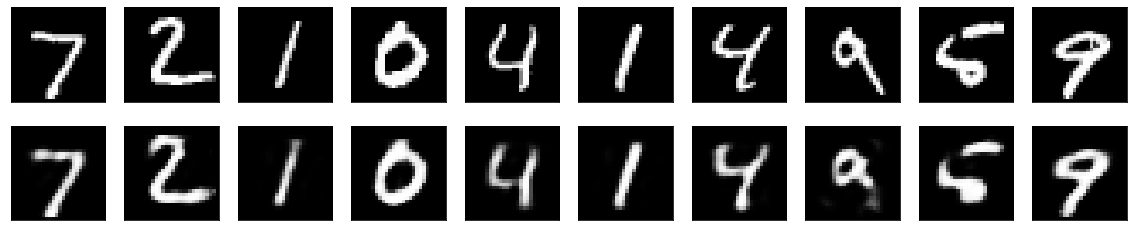

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
